In [1]:
import helper
from glob import glob
import os

from matplotlib import pyplot as plt

from keras.models import Sequential

from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.utils import np_utils
import numpy as np

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [682]:
class GAN(object):
    def __init__(self, img_width, img_height, img_channels, DM_optimizer = RMSprop(lr = 0.0002, decay = 6e-8),\
                 AM_optimizer = RMSprop(lr = 0.0001, decay = 3e-8), input_noice_dim = 100, print_summary = False):
        
        self.input_shape = (img_width, img_height, img_channels)
        self.input_noice_dim = input_noice_dim
        
        if print_summary:
            print("Generator:")
        self.Gen = self.__generator(print_summary)
        
        if print_summary:
            print("\nDiscriminator:")
        self.Dis = self.__discriminator(print_summary)
        
        if print_summary:
            print("\nDM:")
        self.DM = self.__dm(DM_optimizer, print_summary)
        
        if print_summary:
            print("\nAM:")
        self.AM = self.__am(AM_optimizer, print_summary)
        
    def __generator(self, print_summary = False):
        g = Sequential(name = 'generator')
        dropout = 0.5
        depth = 256
        dim = int(self.input_shape[0] / 4)
        
        g.add(Dense(dim * dim * depth, input_dim = self.input_noice_dim))
        g.add(BatchNormalization(momentum = 0.99))
        g.add(LeakyReLU(alpha = 0.2))
        g.add(Reshape((dim, dim, depth)))
        g.add(Dropout(dropout))
        
        g.add(UpSampling2D())
        g.add(Conv2DTranspose(int(depth / 2), 5, padding = 'same'))
        g.add(BatchNormalization(momentum = 0.99))
        g.add(LeakyReLU(alpha = 0.2))
        
        g.add(UpSampling2D())
        g.add(Conv2DTranspose(int(depth / 4), 5, padding = 'same'))
        g.add(BatchNormalization(momentum = 0.99))
        g.add(LeakyReLU(alpha = 0.2))
        
        g.add(Conv2DTranspose(int(depth / 8), 5, padding = 'same'))
        g.add(BatchNormalization(momentum = 0.99))
        g.add(LeakyReLU(alpha = 0.2))
        
        g.add(Conv2DTranspose(self.input_shape[2], 5, padding = 'same'))
        g.add(Activation('tanh')) #tu był sigmoid
        
        if print_summary:
            g.summary()

        return g
    
    def __discriminator(self, print_summary = False):
        d = Sequential(name = "discriminator")
        dropout = 0.5
        depth = 64
        
        d.add(Conv2D(depth * 1, 5, strides = 2, input_shape = self.input_shape, padding = 'same'))
        d.add(LeakyReLU(alpha = 0.2))
        d.add(Dropout(dropout))
        
        d.add(Conv2D(depth * 2, 5, strides = 2, padding = 'same'))
        d.add(LeakyReLU(alpha = 0.2))
        d.add(Dropout(dropout))
        
        d.add(Conv2D(depth * 4, 5, strides = 2, padding = 'same'))
        d.add(LeakyReLU(alpha = 0.2))
        d.add(Dropout(dropout))
        
        d.add(Conv2D(depth * 16, 5, strides = 1, padding = 'same'))
        d.add(LeakyReLU(alpha = 0.2))
        d.add(Dropout(dropout))
        
        d.add(Flatten())
        d.add(Dense(1))
        d.add(Activation('sigmoid'))
        
        if print_summary:
            d.summary()
            
        return d
    
    def __dm(self, optimizer, print_summary = False):
        self.Dis.trainable = True
        dm = Sequential()
        dm.add(self.Dis)
        
        if print_summary:
            dm.summary()
        
        dm.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
        
        return dm
    
    def __am(self, optimizer, print_summary = False):
        #Freezing Discriminator weights during the generator adversarial training
        self.Dis.trainable = False
        am = Sequential()
        am.add(self.Gen)
        am.add(self.Dis)
        
        if print_summary:
            am.summary()
        
        am.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
        
        return am
    
    def train(self, steps, batch_size, dataset, info_rate = 10):
        for i in range(steps):
            r = dataset.get_random_batch(batch_size)
            noise = np.random.normal(0, 0.5, size = [batch_size, self.input_noice_dim])
            f = self.Gen.predict(noise)
            x = np.concatenate((r, f))
            y = np.ones([2 * batch_size, 1])
            y[batch_size:, :] = 0
            dm_loss = self.DM.train_on_batch(x, y)
            
            y = np.ones([2 * batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[2 * batch_size, self.input_noice_dim])
            am_loss = self.AM.train_on_batch(noise, y)
            
            if i % info_rate == 0:
                print("Step:", i, "DM loss:", dm_loss, "AM loss:", am_loss)

In [3]:
celeba_dirs = glob(os.path.join('.', 'img_align_celeba', '*.jpg'))
celeba_dataset = helper.ImagesDataset(celeba_dirs, 'RGB', helper.celeba_preprocessing, width=56, height=56)
print(celeba_dataset.shape)

(202599, 56, 56, 3)


In [688]:
learning_rate = 0.00025
beta1 = 0.45

face_cnn = GAN(56, 56, 3, DM_optimizer = Adam(lr = learning_rate, beta_1 = beta1),\
               AM_optimizer = Adam(lr = learning_rate, beta_1 = beta1), input_noice_dim = 400, print_summary = True)

Generator:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 50176)             20120576  
_________________________________________________________________
batch_normalization_33 (Batc (None, 50176)             200704    
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 50176)             0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
up_sampling2d_17 (UpSampling (None, 28, 28, 256)       0         
_________________________________________________________________
conv2d_transpose_33 (Conv2DT (None, 28, 28, 128)       819328    

In [ ]:
face_cnn.train(30000, 16, celeba_dataset, 1000)

Step: 0 DM loss: [0.616555, 0.5] AM loss: [0.07726845, 1.0]
Step: 1000 DM loss: [0.16826835, 0.9375] AM loss: [0.9270151, 0.4375]


[[0.61124414]]


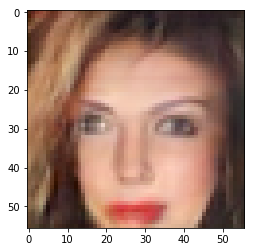

In [681]:
noise = np.random.normal(0, 0.5, size = [1, face_cnn.input_noice_dim])
i = face_cnn.Gen.predict(noise)
print(face_cnn.Dis.predict(i))
#i = (((i - i.min()) * 255) / (i.max() - i.min())).astype(np.uint8)
plt.imshow(helper.image_for_plot(i)[0])

In [669]:
face_cnn.AM.save('face_gen_little_deeper.h5')